**1. Load the observation data**  


In [4]:
import numpy as np
import pandas as pd

# load the data
fname = './slr_data_2020_2025.csv'
df = pd.read_csv(fname)
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

# get the station info
sname = './stn_info.csv'
df_stn = pd.read_csv(sname)
df = pd.merge(df, df_stn, on='stn', how='left')

# filter a dataframe
df = df[(df['swe'] >= 1) & (df['stn_sp'].str[2] == "2")].dropna().copy()
df['slr'] = df['sd_day_max']/df['swe']*10.
df.head()

,stn,date,sd_max,sd_max_time,sd_min,sd_min_time,sd_day_max,rn_day,swe,ta_avg,hm_avg,tw_avg,ws_avg,ta_sd_time,hm_sd_time,tw_sd_time,ws_sd_time,fct_id,stn_sp,slr
0,90.0,2020-01-18,0.7,2020-01-18 10:00:00,0.0,2020-01-18 07:00:00,0.7,15.3,2.3,2.4375,78.8125,0.680689,1.425,1.325000,95.725000,0.848256,1.325000,11D20402,41211110,3.043478
1,90.0,2020-02-08,0.5,2020-02-08 19:00:00,0.0,2020-02-08 18:00:00,0.5,2.6,2.0,1.1000,54.3125,-2.266463,2.400,1.800000,67.750000,-0.796141,1.500000,11D20402,41211110,2.500000
4,90.0,2021-03-01,14.4,2021-03-02 00:00:00,0.0,2021-03-01 10:00:00,14.4,73.4,55.6,2.0375,90.7500,1.109840,3.325,0.120000,95.786667,-0.349523,3.993333,11D20402,41211110,2.589928
5,90.0,2021-03-02,20.4,2021-03-02 14:00:00,13.7,2021-03-02 09:00:00,6.7,7.6,3.4,-1.3000,87.6625,-2.374171,1.800,-1.083333,89.933333,-1.994339,1.066667,11D20402,41211110,19.705882
6,90.0,2021-03-06,2.5,2021-03-07 00:00:00,0.0,2021-03-06 16:00:00,2.5,5.4,4.1,0.5125,83.2000,-0.937887,2.300,-0.755556,88.700000,-1.761074,0.688889,11D20402,41211110,6.097561


**2. Draw scatter plots**  


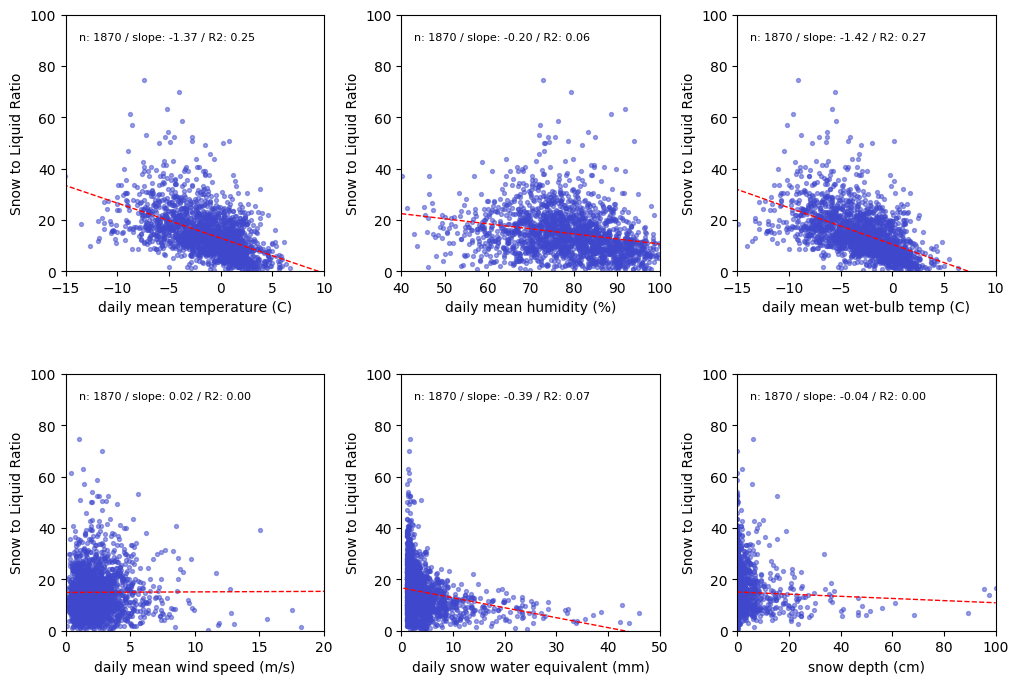

In [17]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

nrow, ncol = 2, 3
fig, ax = plt.subplots(nrow, ncol, figsize = (12,8))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

ymax = 100
ylim = (0, ymax)
color = "#3F48CC"

subset = df.copy()

pred_list = ['ta_avg','hm_avg','tw_avg','ws_avg','swe','sd_min']

for index, pred in enumerate(pred_list):
    if pred == "ta_avg":
        pred_name = "daily mean temperature (C)"
        xmax = 20
        xlim = (-15,10)
    elif pred == "tw_avg":
        pred_name = "daily mean wet-bulb temp (C)"
        xmax = 20
        xlim = (-15,10)
    elif pred == "hm_avg":
        pred_name = "daily mean humidity (%)"
        xmax = 100
        xlim = (40,100)
    elif pred == "ws_avg":
        pred_name = "daily mean wind speed (m/s)"
        xmax = 100
        xlim = (0,20)
    elif pred == "swe":
        pred_name = "daily snow water equivalent (mm)"
        xmax = 50
        xlim = (0,50)
    elif pred == "sd_min":
        pred_name = "snow depth (cm)"
        xmax = 100
        xlim = (0,100)

    i, j = index//ncol, index%ncol
    ax[i,j].set_xlabel(pred_name)
    ax[i,j].set_ylabel('Snow to Liquid Ratio')
    ax[i,j].set_ylim(ylim)
    ax[i,j].set_xlim(xlim)

    X = subset[[pred]]
    Y = subset['slr']
    model = LinearRegression()
    model.fit(X, Y)

    subset['regress'] = model.predict(X)
    r2 = r2_score(subset['slr'], subset['regress'])
    slope = model.coef_[0]
    n = len(subset['slr'])

    ax[i,j].plot([-xmax,xmax], model.predict(pd.DataFrame([-xmax,xmax], columns=[pred])), linewidth=1, color='red', linestyle="--")
    ax[i,j].text(xlim[0]+(xlim[1]-xlim[0])/20,ymax*0.9,'n: {n} / slope: {slope:.2f} / R2: {r2:.2f}'.format(n=n, slope=slope, r2=r2), fontsize=8, color="black")
    ax[i,j].scatter(subset[pred], subset['slr'], color=color, s=8, alpha=0.5)

**3. Multi-variate linear regression**  


In [ ]:
def get_reg_info():
    reg_info = [{"reg_name":"전라권", "fct_key": "11F1%:21F1%:11F2%:21F2%"},
                {"reg_name":"강원내륙", "fct_key": "11D1%"},
                {"reg_name":"강원산지,경북북동산지", "fct_key": "11D201%:11D202%:11D203%:11H108%"},
                {"reg_name":"강원동해안,경북북부동해안", "fct_key": "11D204%:11D205%:11D206%:11H101%"},
                {"reg_name":"경북북부내륙", "fct_key": "11H103%:11H104%:11H105%"},
                {"reg_name":"수도권", "fct_key": "11B1%:11B2%", },
                {"reg_name":"충남권", "fct_key": "11C2%", },
                {"reg_name":"충북", "fct_key": "11C1%"}]

    return reg_info